# Weather Forecast vs Weather Observations in Air Temperature

### Import all libraries

In [2]:
import requests
import pandas as pd
import random
from datetime import datetime
from netCDF4 import Dataset
import numpy as np
import os
import re
import time

### Estrazioni random di 10 stazioni

In [3]:
client_id = '0c8bbb6c-7319-4468-8c63-cece03682584'

In [4]:
#ESTRAGGO LA LISTA DELLE STAZIONI CONTENENTI DETERMINATE INFORMAZIONI (INTERVALLO TEMPORALE, VARIABILE, RISOLUZIONE)
#FONTE FROST API frost.met.no
endpoint='https://frost.met.no/observations/availableTimeSeries/v0.jsonld'
parameters = {
    'referencetime':'2018-01-01/2018-01-31',
    'elements':'air_temperature',
    'timeresolutions':'PT1H',
    'levels':'2'
}
r = requests.get(endpoint, parameters, auth=(client_id,''))
json = r.json()

In [5]:
#ESTRAGGO GLI ID DI QUESTE STAZIONI
a_stations=[]
for i in range(0,len(json['data'])):
    a_stations.append(json['data'][i]['sourceId'])

In [6]:
ind=list(range(0,len(a_stations)))

In [7]:
#ESTRAGGO 10 INDICI A CASO CHE IDENTIFICANO 10 STAZIONI DIVERSE
random.seed(565)
stations = random.sample(a_stations, 10)

In [8]:
#PULISCO LE STRINGHE CONTENENTI GLI INDICI PER ESSERE SICURO DI MATCHARE CORRETTAMENTE
for i in range(0,len(stations)):
    stations[i] = re.sub(r'\:0', '', stations[i])

In [9]:
#CHIEDO INFO SU TUTTE LE STAZIONI 
endpoint = 'https://frost.met.no/sources/v0.jsonld'
parameters = {
}
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()

In [10]:
#FACCIO UNA LISTA CON L'ID DI TUTTE LE STAZIONI
all_stations=[]
for i in range(0,len(json['data'])):
    all_stations.append(json['data'][i]['id'])

In [11]:
#CONTROLLO L'INDICE CHE HANNO LE STAZIONI ESTRATTE ALL'INTERNO DELLA LISTA TOTALE
ind=[]
for i in range(0,len(stations)):
    if stations[i] in all_stations:
        ind.append(all_stations.index(stations[i]))

In [12]:
#ESTRAGGO LE INFORMAZIONI RILEVANTI PER LE 10 STAZIONI SCELTE
infos=[]
for i in range(0,len(ind)):
    infos.append((json['data'][ind[i]]['name'], 
                    json['data'][ind[i]]['geometry']['coordinates'], 
                    json['data'][ind[i]]['id']))
infos  

[('STORFORSHEI', [14.53, 66.3962], 'SN79700'),
 ('BANAK', [24.99, 70.06], 'SN95350'),
 ('LANGFJORDJØKELEN', [21.7223, 70.1227], 'SN92500'),
 ('FLISA II', [12.0125, 60.6141], 'SN6020'),
 ('HONNINGSVÅG LUFTHAVN', [25.9782, 71.0105], 'SN94680'),
 ('HJELMELAND', [6.1498, 59.23], 'SN45770'),
 ('SÆDALEN', [5.3967, 60.35], 'SN50503'),
 ('LENANGSSTRAUMEN', [20.1387, 69.8915], 'SN91180'),
 ('HELLIGVÆR II', [13.8958, 67.4048], 'SN82410'),
 ('NJØS', [6.8608, 61.1792], 'SN55770')]

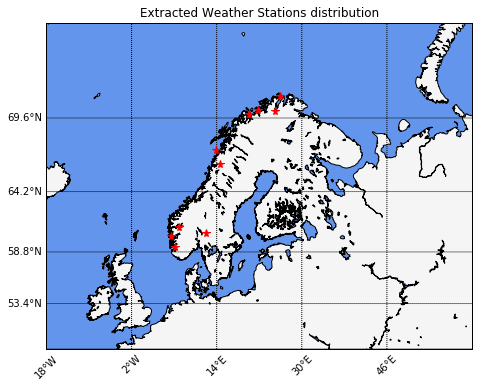

In [13]:
#PLOTTO LA POSIZIONE DELLE 10 STAZIONI ESTRATTE
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

lats, lons = [],[]
for i in range(0,len(infos)):
    try:
        lons.append(infos[i][1][0]) 
        lats.append(infos[i][1][1])
    except KeyError:
        continue


# How much to zoom from coordinates (in degrees)
zoom_scale = 0

# Setup the bounding box for the zoom and bounds of the map
bbox = [48.0,75.0,\
        -18.0,62.0]

plt.figure(figsize=(10,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='whitesmoke',lake_color='cornflowerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='cornflowerblue')

# build and plot coordinates onto map
x,y = m(lons,lats)
m.plot(x,y,'r*',markersize=8)
plt.title("Extracted Weather Stations distribution")
#plt.savefig('Weather_stations.png', format='png', dpi=500)
plt.show()

### Richiesta di osservazioni meteo da Frost API

In [14]:
#VADO AD EFFETTUARE LA RICHIESTA E A CREARE UN DATASET
d = {'time': [], 'observed_air_temperature': [], 'weather_station': []}
obstot=pd.DataFrame(d)
for i in range(0,len(infos)):
        
    endpoint='https://frost.met.no/observations/v0.jsonld'
    parameters = {
        'sources':'{}'.format(infos[i][2]),
        'referencetime':'2018-01-01/2018-02-01',
        'elements':'air_temperature',
        'timeresolutions':'PT1H',
        'levels':'2'
    }
    r = requests.get(endpoint, parameters, auth=(client_id,''))
    # Extract JSON data
    json = r.json()
    
    # This will return a Dataframe with all of the observations in a table format
    data=json['data']
    obs = pd.DataFrame()
    for j in range(len(data)):
        row = pd.DataFrame(data[j]['observations'])
        row['referenceTime'] = data[j]['referenceTime']
        row['observed_air_temperature'] = data[j]['observations'][0]['value']
        obs = obs.append(row)
    obs = obs.reset_index()
        
    obs=obs.drop(columns=list(obs)[:-2])
    obs.columns=['time','observed_air_temperature']
    obs['weather_station']=infos[i][0]
    
    obstot=pd.concat([obstot,obs])
    
    print(i,' ',infos[i][0], ' completed!')

0   STORFORSHEI  completed!
1   BANAK  completed!
2   LANGFJORDJØKELEN  completed!
3   FLISA II  completed!
4   HONNINGSVÅG LUFTHAVN  completed!
5   HJELMELAND  completed!
6   SÆDALEN  completed!
7   LENANGSSTRAUMEN  completed!
8   HELLIGVÆR II  completed!
9   NJØS  completed!


### Slice netCDF forecast data

In [15]:
#IMPORTO I FILE DEI FORECAST SCARICATI IN LOCALE
#FONTE thredds.met.no
forecast=pd.DataFrame()

In [16]:
directory = os.fsencode('/Users/davidgovi/Dropbox/SINTEF/forecast_january18')
files=[] #lista dei file dei forecast presenti nella cartella
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    files.append(filename)

In [17]:
d = {'forecasted_air_temperature': []}
forecast = pd.DataFrame(data=d)

In [18]:
for i in range(0,len(infos)):
    
    for j in range(0,len(files)):
        
        fs = Dataset('/Users/davidgovi/Dropbox/SINTEF/forecast_january18/{}'.format(sorted(files)[j]), "a")
        
        lat = fs.variables['latitude']
        lon = fs.variables['longitude']
        lat_array = lat[:]
        lon_array = lon[:]
        
        dist=np.sqrt(((lon_array-infos[i][1][0])**2.0)+((lat_array-infos[i][1][1])**2.0))
        ind = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
        y=ind[0]
        x=ind[1]
        
        df = pd.DataFrame(fs['air_temperature_2m'][:24,0,y,x]-273.15)
        fs.close()
        df.columns = ['forecasted_air_temperature']
        
        forecast=pd.concat([forecast, df])
        
    print(i,' ',infos[i][0], ' completed!')

0   STORFORSHEI  completed!
1   BANAK  completed!
2   LANGFJORDJØKELEN  completed!
3   FLISA II  completed!
4   HONNINGSVÅG LUFTHAVN  completed!
5   HJELMELAND  completed!
6   SÆDALEN  completed!
7   LENANGSSTRAUMEN  completed!
8   HELLIGVÆR II  completed!
9   NJØS  completed!


In [19]:
obstot.reset_index(inplace=True)
forecast.reset_index(inplace=True)

In [20]:
#FACCIO MERGE DEI DUE DATASET CREATI
airtemp=pd.merge(obstot, forecast, right_index=True, left_index=True)

In [21]:
#PRE PROCESSING SU ALCUNE DELLE VARIABILI
airtemp['observed_air_temperature']=airtemp['observed_air_temperature']+273.15
airtemp['forecasted_air_temperature']=airtemp['forecasted_air_temperature']+273.15
x=airtemp['observed_air_temperature']
y=airtemp['forecasted_air_temperature']
airtemp['absolute_delta']=x-y
#DEFINISCO COSì LA DIFFERENZA RELATIVA TRA FORECAST E OSSERVAZIONE
airtemp['relative_delta']=(x-y)/y
airtemp['relative_delta_perc']=((x-y)/y)*100.0
airtemp['time'] = airtemp['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))
airtemp['hour']=airtemp['time'].apply(lambda x: x.hour)

In [22]:
#ANALIZZO LA DIFFERENZA TRA FORECAST E OSSERVAZIONI SU UN LASSO TEMPORALE DI UN MESE (GENNAIO 2018)
#RAGGRUPPO ORA PER ORA, POICHÉ RITENGO PIù INTERESSANTE PER L'ANALISI
#ASSUMENDO, ED É IN EFFETTI COSÌ, CHE I FORECAST VENGANO PRODOTTI OGNI 24H, SAREBBE RAGIONEVOLE ASPETTARSI DI
#INDIVIDUARE UN AUMENTO DELL'ERRORE PROGREDENDO VERSO LE ORE PIÙ TARDE DEL GIORNO

### Differenza relativa massima, stazione per stazione, ora per ora

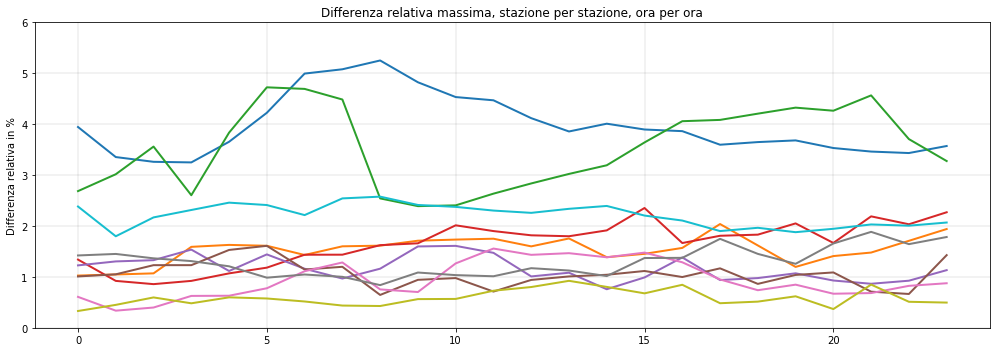

In [23]:
df=airtemp.copy()
df=df.groupby(['weather_station','hour']).max()
df.reset_index(inplace=True)
df['relative_delta_perc']=abs(df['relative_delta_perc'])
df

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,5))
axes = plt.gca()
axes.set_ylim([0,6])
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.title('Differenza relativa massima, stazione per stazione, ora per ora')
plt.ylabel('Differenza relativa in %')
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'STORFORSHEI'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'BANAK'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'LANGFJORDJØKELEN'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'FLISA II'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'HONNINGSVÅG LUFTHAVN'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'HJELMELAND'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'SÆDALEN'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'LENANGSSTRAUMEN'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'HELLIGVÆR II'], linewidth=2)
plt.plot( 'hour', 'relative_delta_perc', data=df.loc[df['weather_station'] == 'NJØS'], linewidth=2)

plt.tight_layout()
#plt.xticks(df['hour'], rotation='vertical', fontsize=8)

### Massima differenza realtiva, ora per ora

In [24]:
#PRENDO SOSTANZIALMENTE L'ERRORE PEGGIORE INDIVIDUATO, TRA TUTTE LE STAZIONI, PER OGNI ORA DEL GIORNO

In [25]:
hgrp=airtemp.copy()

In [26]:
hgrp['relative_delta_perc']=abs(hgrp['relative_delta_perc'])

In [27]:
hgrp=hgrp.groupby(['hour']).max()
hgrp.reset_index(inplace=True)

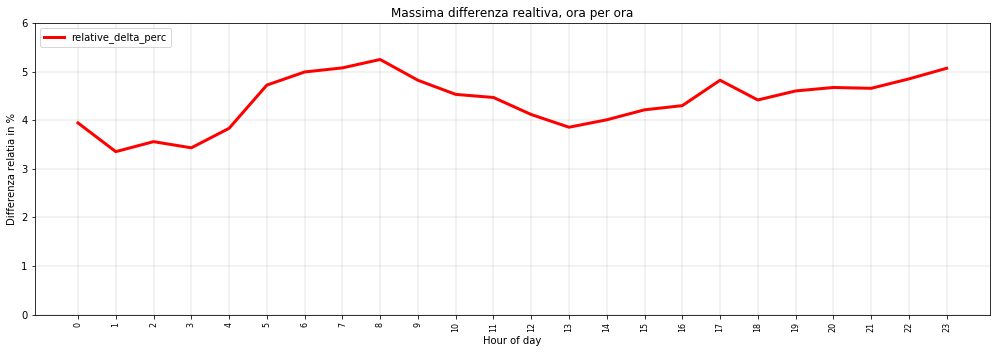

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,5))
axes = plt.gca()
axes.set_ylim([0,6])
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.title('Massima differenza realtiva, ora per ora')
plt.ylabel('Differenza relatia in %')
plt.xlabel('Hour of day')
plt.plot( 'hour', 'relative_delta_perc', data=hgrp, linewidth=3, color='red')
plt.tight_layout()
plt.xticks(hgrp['hour'], rotation='vertical', fontsize=8)
plt.legend(loc='upper left')

plt.show()

### Media differenza relativa, ora per ora

In [29]:
#CONSIDERO ORA L'ANDAMENTO MEDIO DELLA DIFFERENZA TRA FORECAST E OSSERVAZIONI, ANDANDO A CONFERMARE L'IPOTESI DI PARTENZA


In [30]:
hgrp2=airtemp.copy()
hgrp2['relative_delta_perc']=abs(hgrp2['relative_delta_perc'])
hgrp2=hgrp2.groupby(['hour']).mean()
hgrp2.reset_index(inplace=True)

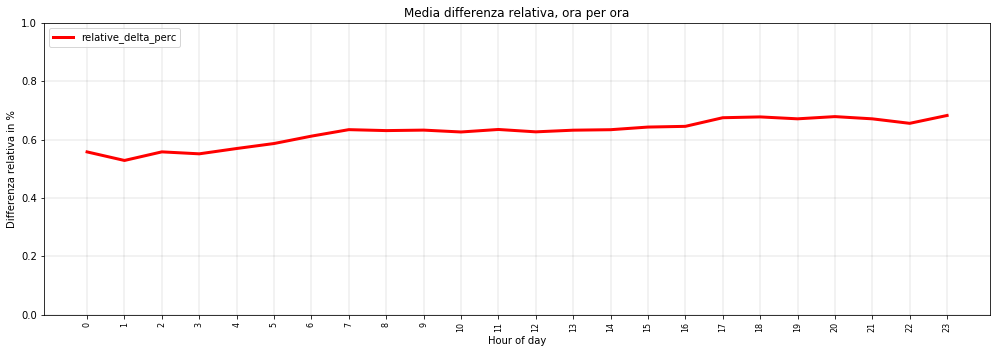

In [31]:
%matplotlib inline

plt.figure(figsize=(14,5))
axes = plt.gca()
axes.set_ylim([0,1])
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.title('Media differenza relativa, ora per ora')
plt.ylabel('Differenza relativa in %')
plt.xlabel('Hour of day')
plt.plot( 'hour', 'relative_delta_perc', data=hgrp2, linewidth=3, color='red')
plt.tight_layout()
plt.xticks(hgrp2['hour'], rotation='vertical', fontsize=8)
plt.legend(loc='upper left')

plt.show()

In [32]:
airtemp.head()

,index_x,time,observed_air_temperature,weather_station,index_y,forecasted_air_temperature,absolute_delta,relative_delta,relative_delta_perc,hour
0,0,2018-01-01 00:00:00,261.25,STORFORSHEI,0,264.949768,-3.699768,-0.013964,-1.396404,0
1,1,2018-01-01 01:00:00,262.25,STORFORSHEI,1,266.344604,-4.094604,-0.015373,-1.537333,1
2,2,2018-01-01 02:00:00,265.95,STORFORSHEI,2,266.966766,-1.016766,-0.003809,-0.380859,2
3,3,2018-01-01 03:00:00,267.55,STORFORSHEI,3,267.261292,0.288708,0.001080,0.108025,3
4,4,2018-01-01 04:00:00,268.35,STORFORSHEI,4,267.653503,0.696497,0.002602,0.260223,4


### Distribuzione della differenza relativa vs ora del giorno

In [33]:
#ANALIZZO MEGLIO LA DISTRIBUZIONE DEI DATI PER CERCARE ULTERIORE RELAZIONE TRA ORA DEL GIORNO E AUMENTO DELL'ERRORE

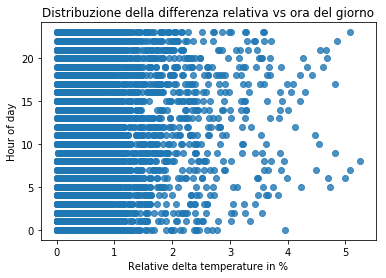

In [34]:
%matplotlib inline

# Plot
area = np.pi*3
colors = (0,0,0)

plt.scatter(abs(airtemp['relative_delta_perc']), airtemp['hour'], alpha=0.8)
plt.title('Distribuzione della differenza relativa vs ora del giorno')
plt.xlabel('Relative delta temperature in %')
plt.ylabel('Hour of day')
plt.show()

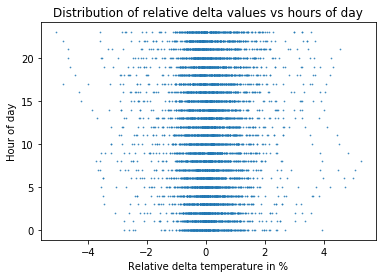

In [35]:
%matplotlib inline

# Plot
area = np.pi*3
colors = (0,0,0)

plt.scatter(airtemp['relative_delta_perc'], airtemp['hour'], alpha=0.8, s=0.5)
plt.title('Distribution of relative delta values vs hours of day')
plt.xlabel('Relative delta temperature in %')
plt.ylabel('Hour of day')
plt.show()

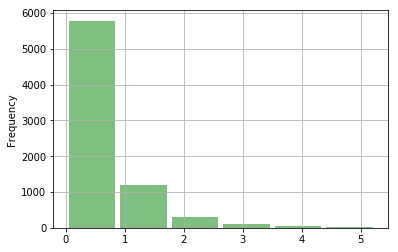

In [36]:
abs(airtemp['relative_delta_perc']).plot.hist(grid=True, bins=6, rwidth=0.9,
                   color='g', alpha=0.5)

### Distribuzione della differenza relativa, stazione per stazione

In [37]:
#SI PUò OSSERVARE COME ALCUNE STZIONI PRODUCANO FORECAST MIGLIORI
#I VALORI DELLA DIFFERENZA SONO SUDIVISI IN INTERVALLI PER FACILITARE LA LETTURA DELLA VISUALIZZAZIONE

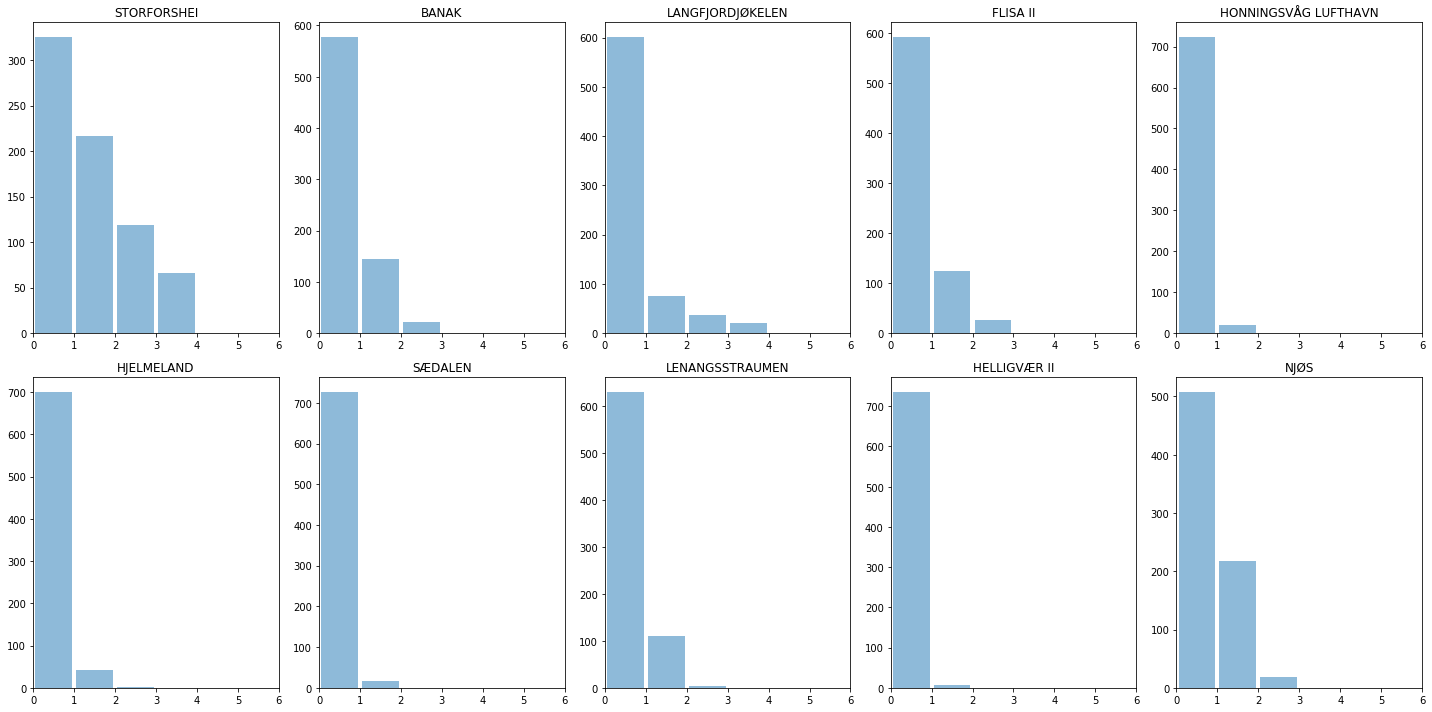

In [38]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

ax0.hist(abs(airtemp[airtemp.weather_station=='STORFORSHEI']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax0.set_title('STORFORSHEI')
ax0.set_xlim([0,6])

ax1.hist(abs(airtemp[airtemp.weather_station=='BANAK']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax1.set_title('BANAK')
ax1.set_xlim([0,6])

ax2.hist(abs(airtemp[airtemp.weather_station=='LANGFJORDJØKELEN']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax2.set_title('LANGFJORDJØKELEN')
ax2.set_xlim([0,6])

ax3.hist(abs(airtemp[airtemp.weather_station=='FLISA II']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax3.set_title('FLISA II')
ax3.set_xlim([0,6])

ax4.hist(abs(airtemp[airtemp.weather_station=='HONNINGSVÅG LUFTHAVN']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax4.set_title('HONNINGSVÅG LUFTHAVN')
ax4.set_xlim([0,6])

ax5.hist(abs(airtemp[airtemp.weather_station=='HJELMELAND']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax5.set_title('HJELMELAND')
ax5.set_xlim([0,6])

ax6.hist(abs(airtemp[airtemp.weather_station=='SÆDALEN']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax6.set_title('SÆDALEN')
ax6.set_xlim([0,6])

ax7.hist(abs(airtemp[airtemp.weather_station=='LENANGSSTRAUMEN']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax7.set_title('LENANGSSTRAUMEN')
ax7.set_xlim([0,6])

ax8.hist(abs(airtemp[airtemp.weather_station=='HELLIGVÆR II']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax8.set_title('HELLIGVÆR II')
ax8.set_xlim([0,6])

ax9.hist(abs(airtemp[airtemp.weather_station=='NJØS']['relative_delta_perc']), bins=range(0, 5), rwidth=0.9, alpha=0.5)
ax9.set_title('NJØS')
ax9.set_xlim([0,6])

fig.tight_layout()
plt.show()

### Heatmap

In [39]:
temporary=airtemp.copy()

In [40]:
temporary['0-1']=0
temporary['1-2']=0
temporary['2-3']=0
temporary['3-4']=0
temporary['4-5']=0
temporary['>=5']=0
temporary['relative_delta_perc']=abs(temporary['relative_delta_perc'])

In [41]:
for i in range(0,len(temporary)):
    if temporary.at[i, 'relative_delta_perc']<1:
        temporary.at[i, '0-1']=1
    elif temporary.at[i, 'relative_delta_perc']<2:
        temporary.at[i, '1-2']=1
    elif temporary.at[i, 'relative_delta_perc']<3:
        temporary.at[i, '2-3']=1
    elif temporary.at[i, 'relative_delta_perc']<4:
        temporary.at[i, '3-4']=1
    elif temporary.at[i, 'relative_delta_perc']<5:
        temporary.at[i, '4-5']=1
    else:
        temporary.at[i, '>=5']=1

In [42]:
grpd=temporary.groupby(['weather_station']).sum()

In [43]:
grpd.reset_index(inplace=True)

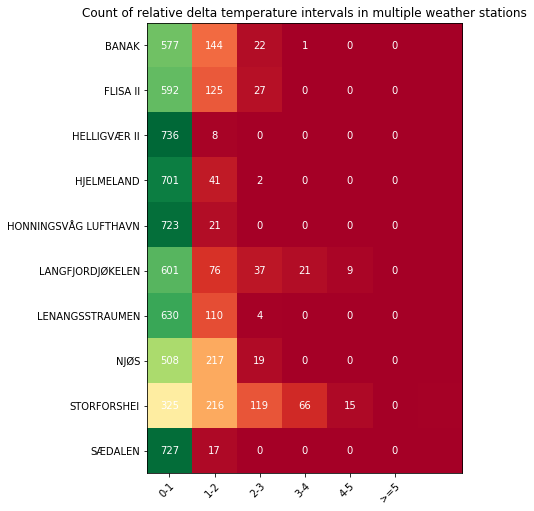

In [45]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

wstation = list(grpd.weather_station)
rel_delta = ['0-1','1-2','2-3','3-4','4-5','>=5']

values = np.array([[577,144,22,1,0,0,0],
                    [592,125,27,0,0,0,0],
                    [736,8,0,0,0,0,0],
                    [701,41,2,0,0,0,0],
                    [723,21,0,0,0,0,0],
                    [601,76,37,21,9,0,0],
                    [630,110,4,0,0,0,0],
                    [508,217,19,0,0,0,0],
                    [325,216,119,66,15,0,3],
                    [727,17,0,0,0,0,0]])


fig, ax = plt.subplots(figsize=(7,15))
im = ax.imshow(values, cmap='RdYlGn')

# We want to show all ticks...
ax.set_xticks(np.arange(len(rel_delta)))
ax.set_yticks(np.arange(len(wstation)))
# ... and label them with the respective list entries
ax.set_xticklabels(rel_delta)
ax.set_yticklabels(wstation)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(wstation)):
    for j in range(len(rel_delta)):
        text = ax.text(j, i, values[i, j],
                       ha="center", va="center", color="w")

ax.set_title('Count of relative delta temperature intervals in multiple weather stations')
fig.tight_layout()
plt.show()